# Driver Distraction Classification Model

This repository contains code for a driver distraction classification model which utilizes Convolutional Neural Networks (CNNs) and transfer learning techniques. The model is designed to classify images of drivers into different distraction categories based on the input images. These categories include various distractions such as texting, talking on the phone, drinking, and other behaviors.

### Outlook

This driver distraction classification model is an amalgamation of custom-built Convolutional Neural Networks and pre-trained models (VGG16 and MobileNetV3) utilizing transfer learning. The model classifies images into different categories of driver distractions and could be used to improve road safety by alerting drivers or taking preventive measures when a distraction is detected.


In [172]:
# Standard Libraries
import os
import random

# Data Handling and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix

# TensorFlow and Keras for Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, optimizers, Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNet, MobileNetV3Large
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Nadam

First of all, we are going to load the images and import the required libraries for handling the data, training the models, and visualizing results. The following classes are relevant for our models:

- **c0:** safe driving

- **c1:** texting - right

- **c2:** talking on the phone - right
- **c3:** texting - left
- **c4:** talking on the phone - left
- **c5:** operating the radio
- **c6:** drinking
- **c7:** reaching behind
- **c8:** hair and makeup
- **c9:** talking to passenger

In [173]:
# The images are in a folder named 'shapes/training'
train_data = os.path.join('../imgs/train')
test_data = os.path.join('../imgs/test/')
driver_imgs_list = pd.read_csv(os.path.join('../driver_imgs_list.csv'))
sample_submission = pd.read_csv(os.path.join('../sample_submission.csv'))

# The folder contains a subfolder for each class of shape
all_entries = os.listdir(train_data)

# Filter out only the relevant classes (c0 to c9)
classes = sorted(entry for entry in all_entries if entry in ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])

classes_names = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5': 'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


# 2. Data Exploration

As a second step, we are going to display a random sample of images from the training dataset along with their corresponding class names. This will help us to better understand the data.

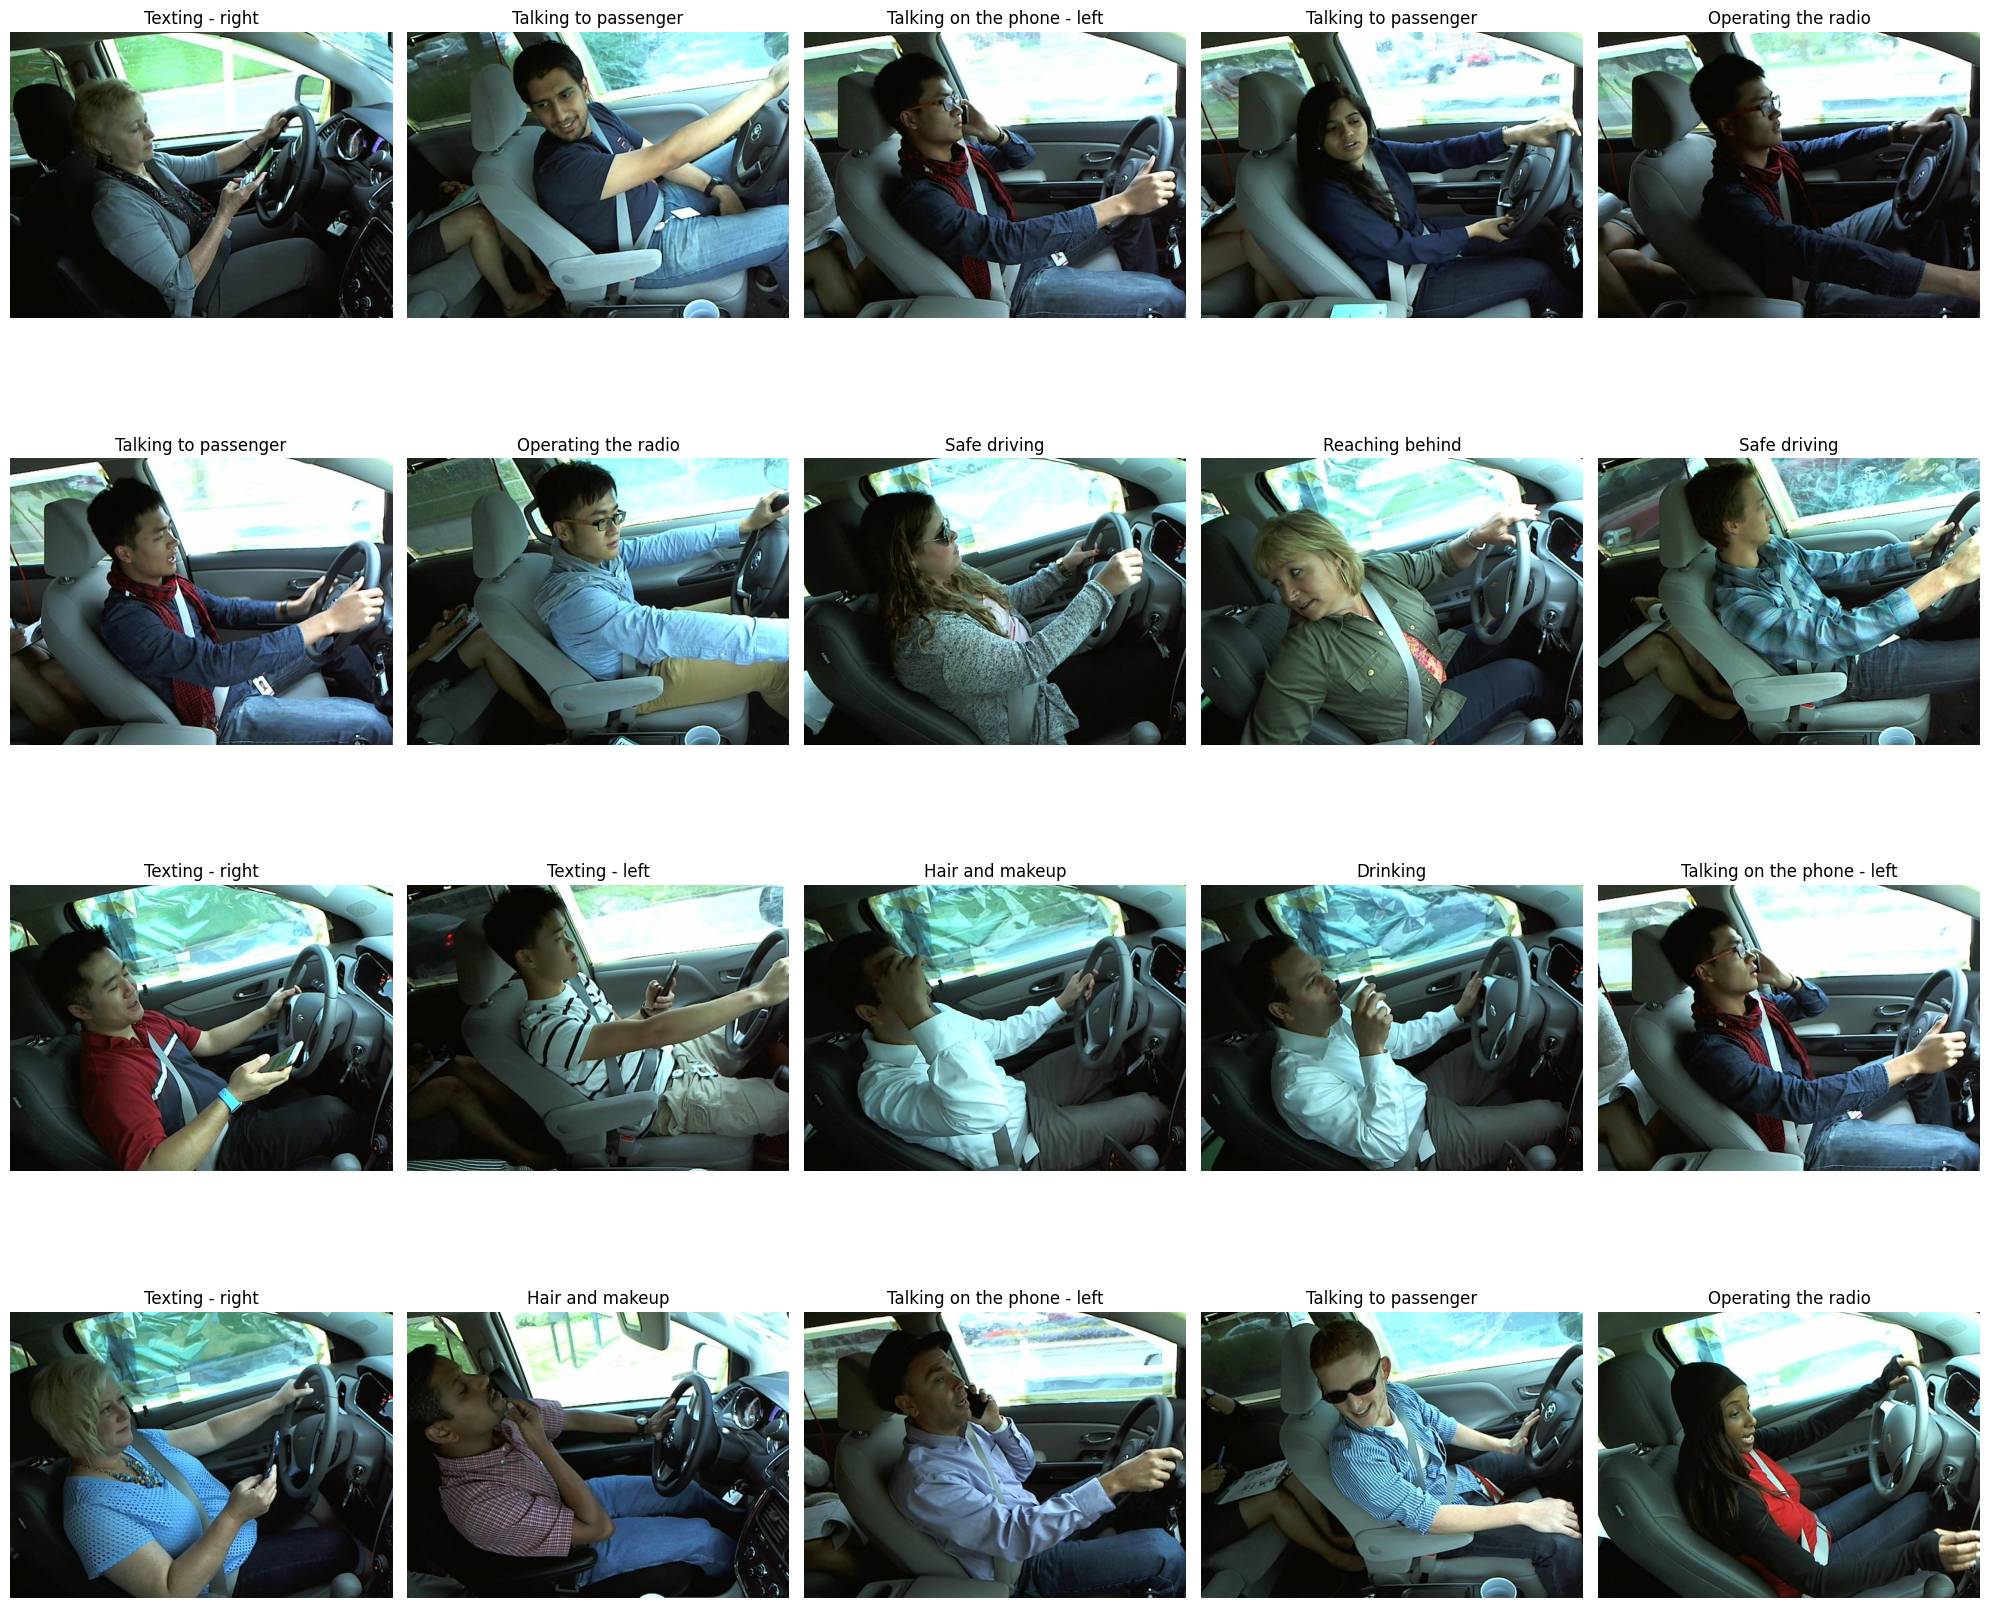

In [174]:
fig = plt.figure(figsize=(20, 18))
columns = 5
rows = 4
for i in range(1, columns*rows +1):
    pic_idx = random.randint(0, driver_imgs_list.shape[0])
    im = Image.open(os.path.join(train_data,
                                 str(driver_imgs_list.loc[pic_idx, 'classname']),
                                 str(driver_imgs_list.loc[pic_idx, 'img'])))
    fig.add_subplot(rows, columns, i)
    plt.imshow(im)
    
    # Capitalize the first letter of class name
    class_name = classes_names[driver_imgs_list.loc[pic_idx, 'classname']].capitalize()
    
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

# 3. Data Preparation

As a third step, we are going to prepare the data to be injected into the neural network models for training:

### 1. Batch Size
Based on previous model runs, we will set the batch size to 20 which specifies the number of training examples utilized in one iteration. The batch size can affect the training dynamics and speed. Hence, we avoid running out of memory, our models weights are updated more frequently to increase the performance, and it allows for an improved regularization effect (which may avoid overifitting). 

### 2. Data Generator
**ImageDataGenerator** is used to augment and rescale images. However, as noted in the comment, no data augmentation is being used because it reduces accuracy in this specific scenario. The generator rescales the images by dividing each pixel value by 255, converting them to a scale between 0 and 1. The **validation_split** parameter is set to 0.3, meaning that 30% of the data will be used for validation.

### 3. Preparing Data for CNN - Image Size 128x128
We are going to define a training data and validation generator for our CNN with an image size of 128x128. Hence, we can train our model and validate the accuracy of it to avoid any over or underfitting before applying it to the test data. The generator will the process images into batches of 20 and will resize them to 128x128 pixels. 

### 4. Preparing Data for VGG16 and MobileNetV3 - Image Size 224x224
Since VGG16 and MobileNetV3 expect input images of size 224x224, we will define a seperate generator for training and validating the data with an image size of 224x224. 

In [175]:
# No data augmentation as it reduces accuracy

batch_size = 20

# Data generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

# Preparing data for Model 1 (e.g. VGG16) - image size 224x224
print("Preparing data for size 128x128...")
train_generator_128 = datagen.flow_from_directory(
    train_data,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator_128 = datagen.flow_from_directory(
    train_data,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

# Preparing data for Model 3 - image size 64x64
print("Preparing data for size 224x224...")
train_generator_224 = datagen.flow_from_directory(
    train_data,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator_224 = datagen.flow_from_directory(
    train_data,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')


Preparing data for size 128x128...
Found 15702 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.
Preparing data for size 224x224...
Found 15702 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.


# 4. Modelling

Next, we are going to inject our training data into the three choosen models:

**1. CNN (Self-created):**

The self-created simple CNN is a custom convolutional neural Nnetwork, built from scratch to learn features and patterns specific to the dataset, providing the flexibility to design the architecture tailored to the task's requirements. This model consists of multiple convolutional layers.

**2. VGG16 (Transfered Model):**

In contract to our self-defined CNN, VGG16 is a complex convolutional neural network with 16 layers which leverages transfer learning from pre-trained weights on ImageNet.

**3. MobileNetV3 Large (Transfered Model):**

In contrast to VGG16, MobileNetV3 is an efficient and lightweight convolutional neural network designed for mobile and edge devices. It employs transfer learning with a focus on high performance with a smaller model size, making it faster and more resource-efficient compared to VGG16.

### 1. Choosing Callbacks for Our Models

We are going to select two important callbacks to train our models: Learning Rate Scheduling and Model Checkpointing:

#### Learning Rate Scheduling

- **Task**: Dynamically adjusts the learning rate during training. 
- **Purpose**: The learning rate is a hyperparameter that determines the step size at each iteration while moving toward a minimum of a loss function. The Learning Rate Scheduling supports the model in adjusting the learning rate during the training, which can lead to an improved performance and faster convergence. 

#### Model Checkpointing

- **Task**: Saves the model weights at different points during training.
- **Purpose**: During the training process, a model might perform better in some epochs compared to others. Model checkpointing allows us to save the model weights only when there is an improvement in performance. Hence, we can prevent the loss of model progress if the training of a model is interrupted or if overfitting occurs toward the end of training the model.

### 2. Training the Model
As a next step, we are going to train the different models. To reduce the training time, especially with a complex model such as VGG16 (over 138 million parameters), we are going to train our models with only 5 epochs and 20-image batches.

In [176]:
def train_model(model, model_name, train_generator, validation_generator, batch_size, num_epochs=5):
    # Defining callbacks
    checkpoint = ModelCheckpoint(f"{model_name}_best_weights.h5", save_best_only=True)
    #early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(patience=2, factor=0.2)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator, 
        validation_steps = validation_generator.samples // batch_size,
        epochs = num_epochs,
        callbacks=[checkpoint, reduce_lr],
        verbose=2)
    
    return history

## A. Convolutional Neural Network

The first model we are going to train will be our self-created convolutional neural network:

### 1. Input Shape
For the training images, we will use an image size of 128x128 with 3 channels (RGB).

### 2. First Convolutional Block
- **Conv2D Layer**: We use a 2D convolutional layer as the first layer with 32 filters of size 6x6. This extracts features from the input image, as each filter is designed to learn and detect different features of the image.
  
- **Activation Function (ReLU)**: We introduce non-linearity into the model by applying the ReLU activation function, which replaces all negative pixel values in the feature map with zero.
  
- **Batch Normalization**: We include batch normalization to normalize the activations of the previous layer at each batch, improving the training speed and reducing sensitivity to network initialization.
  
- **MaxPooling2D Layer**: We employ max pooling to reduce the spatial dimensions (height, width) of the input, reducing computation and making feature detection invariant to scale and orientation changes.
  
- **Dropout Layer**: We utilize dropout, temporarily disabling neurons at each iteration (25% dropout rate) to prevent overfitting by adding regularization.

### 3. Additional Convolutional Blocks
We have designed three more convolutional blocks similar to the first one but with different filter sizes and counts. As we increase the number of filters, our network can learn more complex features. Decreasing filter sizes enables the network to learn finer details.

### 4. Flattening
After the last convolutional block, we flatten the 3D output to one dimension. Flattening is necessary for connecting the output of the convolutional blocks to the fully connected layers.

### 5. Fully Connected Layer
- **Dense Layer with 512 Units**: We use a dense layer with 512 units to learn non-linear combinations of high-level features represented by the output of the previous layer.

- **Batch Normalization and Dropout**: We apply batch normalization and dropout for faster training and regularization, similar to the convolutional blocks.

### 6. Output Layer
- **Dense Layer**: Our final dense layer has a number of units equal to the number of classes and represents the class scores.
  
- **Activation Function (Softmax)**: We apply the softmax activation function to convert the raw class scores into probabilities, which makes the output easier to interpret.

### 7. Defining the Optimizer
We will compile our CNN model using the Adam optimizer. This optimizer adapts the learning rate for each parameter based on its historical gradients, which can lead to faster convergence.

### 8. Testing Different Learning Rates
We will train our model with different learning rates to see how they affect the convergence and performance:
- **High learning rate (e.g. 0.01)**: This can lead to quick convergence, but may cause oscillations in the loss.
  
- **Medium learning rate (e.g. 0.001)**: This learning rate may strike a good balance between fast convergence and stability.
  
- **Low learning rate (e.g. 0.0001)**: A lower learning rate converges slowly but might find a better minimum, possibly improving performance.

In [177]:
def create_cnn_model(input_shape, num_classes, learning_rate):
    cnn_model = Sequential()
    
    # First Convolutional Block
    cnn_model.add(Conv2D(32, (6, 6), input_shape=input_shape, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Dropout(0.25))
    
    # Second Convolutional Block
    cnn_model.add(Conv2D(64, (5, 5), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Dropout(0.25))
    
    # Third Convolutional Block
    cnn_model.add(Conv2D(128, (4, 4), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Dropout(0.25))
    
    # Fourth Convolutional Block
    cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Dropout(0.25))
    
    # Fully connected layer
    cnn_model.add(Flatten())
    cnn_model.add(Dense(512, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.5))
    
    # Output layer
    cnn_model.add(Dense(num_classes, activation='softmax'))
    
    # Define the optimizer with the specified learning rate
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    
    # Compile the model
    cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return cnn_model

In [178]:
# Creating the model with learning rate of 0.01
lr = 0.01
model_cnn_lr1 = create_cnn_model(train_generator_128.image_shape, train_generator_128.num_classes, lr)

# Training the model
history_cnn_lr1 = train_model(
    model=model_cnn_lr1,
    model_name="cnn_lr1",
    train_generator=train_generator_128,
    validation_generator=validation_generator_128,
    batch_size=batch_size
)

Epoch 1/5
785/785 - 176s - loss: 1.5841 - accuracy: 0.5183 - val_loss: 1.1705 - val_accuracy: 0.6234 - lr: 0.0100 - 176s/epoch - 224ms/step
Epoch 2/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


785/785 - 158s - loss: 0.7004 - accuracy: 0.7740 - val_loss: 0.4547 - val_accuracy: 0.8509 - lr: 0.0100 - 158s/epoch - 201ms/step
Epoch 3/5
785/785 - 148s - loss: 0.6680 - accuracy: 0.7854 - val_loss: 0.2183 - val_accuracy: 0.9315 - lr: 0.0100 - 148s/epoch - 188ms/step
Epoch 4/5
785/785 - 147s - loss: 0.4862 - accuracy: 0.8475 - val_loss: 0.2689 - val_accuracy: 0.9187 - lr: 0.0100 - 147s/epoch - 187ms/step
Epoch 5/5
785/785 - 146s - loss: 0.4338 - accuracy: 0.8635 - val_loss: 0.1703 - val_accuracy: 0.9549 - lr: 0.0100 - 146s/epoch - 186ms/step


In [179]:
# Creating the model with learning rate of 0.001
lr = 0.001
model_cnn_lr2 = create_cnn_model(train_generator_128.image_shape, train_generator_128.num_classes, lr)

# Training the model
history_cnn_lr2 = train_model(
    model=model_cnn_lr2,
    model_name="cnn_lr2",
    train_generator=train_generator_128,
    validation_generator=validation_generator_128,
    batch_size=batch_size
)

Epoch 1/5
785/785 - 152s - loss: 1.1445 - accuracy: 0.6462 - val_loss: 0.5928 - val_accuracy: 0.7884 - lr: 0.0010 - 152s/epoch - 193ms/step
Epoch 2/5
785/785 - 148s - loss: 0.3417 - accuracy: 0.8942 - val_loss: 0.1941 - val_accuracy: 0.9484 - lr: 0.0010 - 148s/epoch - 189ms/step
Epoch 3/5
785/785 - 147s - loss: 0.2098 - accuracy: 0.9357 - val_loss: 0.1432 - val_accuracy: 0.9557 - lr: 0.0010 - 147s/epoch - 188ms/step
Epoch 4/5
785/785 - 138s - loss: 0.1840 - accuracy: 0.9420 - val_loss: 0.7383 - val_accuracy: 0.7671 - lr: 0.0010 - 138s/epoch - 176ms/step
Epoch 5/5
785/785 - 134s - loss: 0.2376 - accuracy: 0.9262 - val_loss: 0.1364 - val_accuracy: 0.9555 - lr: 0.0010 - 134s/epoch - 171ms/step


In [180]:
# Creating the model with learning rate of 0.0001
lr = 0.0001
model_cnn_lr3 = create_cnn_model(train_generator_128.image_shape, train_generator_128.num_classes, lr)

# Training the model
history_cnn_lr3 = train_model(
    model=model_cnn_lr3,
    model_name="cnn_lr3",
    train_generator=train_generator_128,
    validation_generator=validation_generator_128,
    batch_size=batch_size
)

Epoch 1/5
785/785 - 135s - loss: 2.1840 - accuracy: 0.3495 - val_loss: 1.5424 - val_accuracy: 0.5311 - lr: 1.0000e-04 - 135s/epoch - 172ms/step
Epoch 2/5
785/785 - 138s - loss: 1.0850 - accuracy: 0.6476 - val_loss: 0.4697 - val_accuracy: 0.8690 - lr: 1.0000e-04 - 138s/epoch - 175ms/step
Epoch 3/5
785/785 - 136s - loss: 0.6581 - accuracy: 0.7875 - val_loss: 0.2676 - val_accuracy: 0.9280 - lr: 1.0000e-04 - 136s/epoch - 173ms/step
Epoch 4/5
785/785 - 134s - loss: 0.4665 - accuracy: 0.8495 - val_loss: 0.1651 - val_accuracy: 0.9567 - lr: 1.0000e-04 - 134s/epoch - 171ms/step
Epoch 5/5
785/785 - 140s - loss: 0.3297 - accuracy: 0.8959 - val_loss: 0.1283 - val_accuracy: 0.9610 - lr: 1.0000e-04 - 140s/epoch - 179ms/step


## B. Transfer Learning: VGG16

The second model we are going to train is VGG16, which is a transfer learning model.

### 1. Input Shape
We will adapt VGG16 to a different input shape as our custom model: 224x224. This is mainly due to the fact that the model has been pretrained with images of size 224x224.

### 2. Pre-trained Base Model
We will use VGG16, a pre-trained deep learning model in feature extraction from images. It has been trained on a large dataset (ImageNet), and we will leverage its weights.

### 3. Freezing the Base Model
We will freeze the weights and biases of the pre-trained VGG16 model. This ensures that the valuable features already learned by VGG16 are not altered during further training on our new dataset.

### 4. Flattening
We will flatten the output of VGG16's last convolutional block. This is necessary for transforming the multi-dimensional tensor into a one-dimensional vector, which will then be used for classification in the fully connected layer.

### 5. Custom Output Layer
- **Activation Function (Softmax)**: Similar to our custom CNN, we are using the softmax activation function here. This converts raw scores into probabilities which sum up to 1, making it easier to interpret the output.

### 6. Defining Optimizer 
We will compile the VGG16 model using an optimizer (in this case, Adam) which adjusts the learning rate for each parameter based on its previous gradients.

### 7. Testing different Learning Rates
We are going to train the model with different learning rates which determines how much the weights are adjusted after backpropagation identifies their affect on loss. To avoid long training times, we will traint the model more quickly compared to the self-defined CNN:
- **High learning rate (e.g. 0.1)**: This learning rate can converge quickly, but there's a risk that the loss will oscillate back and forth across the minimum.

- **Medium learning rate (e.g. 0.01)**: This learning rate will be the baseline and might be a good balance between fast convergence and stability.
- **Low learning rate (e.g. 0.001)**: This learning rate will converge very slowly, but might result in better performance as it takes small steps to find a good minimum.


In [181]:
def create_vgg16_model(input_shape, num_classes, learning_rate):
    # Load the VGG16 model without the final output layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers
    x = Flatten()(base_model.output)
    output = Dense(num_classes, activation='softmax')(x)
    
    # Define a new model
    model = Model(inputs=base_model.input, outputs=output)
    
    # Define the optimizer with the specified learning rate
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [182]:
# Creating the model with learning rate of 0.001
lr = 0.1
model_vgg16_lr1 = create_vgg16_model(train_generator_224.image_shape, train_generator_224.num_classes, lr)

# Training the model
history_vgg16_lr1 = train_model(
    model=model_vgg16_lr1,
    model_name="vgg16_lr1",
    train_generator=train_generator_224,
    validation_generator=validation_generator_224,
    batch_size=batch_size
)

Epoch 1/5
785/785 - 1468s - loss: 26.2707 - accuracy: 0.8592 - val_loss: 3.2143 - val_accuracy: 0.9792 - lr: 0.1000 - 1468s/epoch - 2s/step
Epoch 2/5
785/785 - 1391s - loss: 6.6511 - accuracy: 0.9601 - val_loss: 10.0994 - val_accuracy: 0.9493 - lr: 0.1000 - 1391s/epoch - 2s/step
Epoch 3/5
785/785 - 1387s - loss: 6.0911 - accuracy: 0.9688 - val_loss: 9.3026 - val_accuracy: 0.9634 - lr: 0.1000 - 1387s/epoch - 2s/step
Epoch 4/5
785/785 - 1336s - loss: 0.7374 - accuracy: 0.9958 - val_loss: 1.4040 - val_accuracy: 0.9948 - lr: 0.0200 - 1336s/epoch - 2s/step
Epoch 5/5
785/785 - 1335s - loss: 0.1782 - accuracy: 0.9989 - val_loss: 1.8432 - val_accuracy: 0.9930 - lr: 0.0200 - 1335s/epoch - 2s/step


In [183]:
# Creating the model with learning rate of 0.01
lr = 0.01
model_vgg16_lr2 = create_vgg16_model(train_generator_224.image_shape, train_generator_224.num_classes, lr)

# Training the model
history_vgg16_lr2 = train_model(
    model=model_vgg16_lr2,
    model_name="vgg16_lr2",
    train_generator=train_generator_224,
    validation_generator=validation_generator_224,
    batch_size=batch_size
)

Epoch 1/5
785/785 - 1336s - loss: 2.5453 - accuracy: 0.8691 - val_loss: 0.8200 - val_accuracy: 0.9472 - lr: 0.0100 - 1336s/epoch - 2s/step
Epoch 2/5
785/785 - 1324s - loss: 0.6218 - accuracy: 0.9626 - val_loss: 0.5716 - val_accuracy: 0.9673 - lr: 0.0100 - 1324s/epoch - 2s/step
Epoch 3/5
785/785 - 1340s - loss: 0.5764 - accuracy: 0.9716 - val_loss: 0.3999 - val_accuracy: 0.9859 - lr: 0.0100 - 1340s/epoch - 2s/step
Epoch 4/5
785/785 - 1336s - loss: 0.6353 - accuracy: 0.9746 - val_loss: 0.9871 - val_accuracy: 0.9640 - lr: 0.0100 - 1336s/epoch - 2s/step
Epoch 5/5
785/785 - 1341s - loss: 0.3397 - accuracy: 0.9868 - val_loss: 0.3687 - val_accuracy: 0.9909 - lr: 0.0100 - 1341s/epoch - 2s/step


In [184]:
# Creating the model with learning rate of 0.001
lr = 0.001
model_vgg16_lr3 = create_vgg16_model(train_generator_224.image_shape, train_generator_224.num_classes, lr)

# Training the model
history_vgg16_lr3 = train_model(
    model=model_vgg16_lr3,
    model_name="vgg16_lr3",
    train_generator=train_generator_224,
    validation_generator=validation_generator_224,
    batch_size=batch_size
)

Epoch 1/5
785/785 - 1333s - loss: 0.2502 - accuracy: 0.9336 - val_loss: 0.0514 - val_accuracy: 0.9857 - lr: 0.0010 - 1333s/epoch - 2s/step
Epoch 2/5
785/785 - 1333s - loss: 0.0556 - accuracy: 0.9829 - val_loss: 0.0852 - val_accuracy: 0.9725 - lr: 0.0010 - 1333s/epoch - 2s/step
Epoch 3/5
785/785 - 1333s - loss: 0.0230 - accuracy: 0.9927 - val_loss: 0.2246 - val_accuracy: 0.9455 - lr: 0.0010 - 1333s/epoch - 2s/step
Epoch 4/5
785/785 - 1325s - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0149 - val_accuracy: 0.9966 - lr: 2.0000e-04 - 1325s/epoch - 2s/step
Epoch 5/5
785/785 - 1329s - loss: 4.9977e-04 - accuracy: 1.0000 - val_loss: 0.0148 - val_accuracy: 0.9972 - lr: 2.0000e-04 - 1329s/epoch - 2s/step


## C. Transfer Learning: MobileNetV3

For our third model, we are going to employ MobileNetV3 Large and fine-tune it for our specific task:

### 1. Input Shape
We will adapt MobileNetV3 to the same input shape as the other transfer learning model, VGG16.

### 2. Pre-trained Base Model
We will use MobileNetV3 but will not include the final output layer as we want to add custom layers tailored for our specific problem. 

### 2. Freeze Base Model Layers
To retain the knowledge that MobileNetV3 has gained from the ImageNet dataset, we will freeze the layers in the base model. This means the weights in these layers will not be updated during the training.

### 3. Add Custom Layers
We will append custom layers to the model to adapt it to our classification task:
- **Flatten Layer**: We flatten the output of the base model to make it suitable for the fully connected layer. 

### 4. Defining Optimizer 
We will compile the MobileNetV3 model using an optimizer (in this case, Adam) which adjusts the learning rate for each parameter based on its previous gradients.

### 5. Testing different Learning Rates
We are going to train the model with different learning rates which determines how much the weights are adjusted after backpropagation identifies their affect on loss:
- **High learning rate (e.g. 0.01)**: This learning rate can converge quickly, but there's a risk that the loss will oscillate back and forth across the minimum.

- **Medium learning rate (e.g. 0.001)**: This learning rate will be the baseline and might be a good balance between fast convergence and stability.
- **Low learning rate (e.g. 0.0001)**: This learning rate will converge very slowly, but might result in better performance as it takes small steps to find a good minimum.


In [185]:
def create_mobilenetv3_model(input_shape, num_classes, learning_rate):
    # Load MobileNetV3 model without the final output layer
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = Flatten()(base_model.output)
    output = Dense(num_classes, activation='softmax')(x)

    # Define a new model
    model = Model(inputs=base_model.input, outputs=output)

    # Define optimizer with the specified learning rate
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [186]:
# Creating the model with learning rate of 0.01
lr = 0.01
model_mobilenetv3_lr1 = create_mobilenetv3_model(train_generator_224.image_shape, train_generator_224.num_classes, lr)

# Training the model
history_mobilenetv3_lr1 = train_model(
    model=model_mobilenetv3_lr1,
    model_name="mobilenetv3_lr1",
    train_generator=train_generator_224,
    validation_generator=validation_generator_224,
    batch_size=batch_size
)

Epoch 1/5
785/785 - 92s - loss: 4.9906 - accuracy: 0.5682 - val_loss: 4.5175 - val_accuracy: 0.6247 - lr: 0.0100 - 92s/epoch - 117ms/step
Epoch 2/5
785/785 - 85s - loss: 2.6685 - accuracy: 0.7458 - val_loss: 2.5875 - val_accuracy: 0.7580 - lr: 0.0100 - 85s/epoch - 109ms/step
Epoch 3/5
785/785 - 85s - loss: 2.3595 - accuracy: 0.8060 - val_loss: 5.3143 - val_accuracy: 0.7525 - lr: 0.0100 - 85s/epoch - 108ms/step
Epoch 4/5
785/785 - 89s - loss: 2.1952 - accuracy: 0.8288 - val_loss: 1.5321 - val_accuracy: 0.8729 - lr: 0.0100 - 89s/epoch - 114ms/step
Epoch 5/5
785/785 - 86s - loss: 2.1977 - accuracy: 0.8454 - val_loss: 4.1913 - val_accuracy: 0.7754 - lr: 0.0100 - 86s/epoch - 110ms/step


In [187]:
# Creating the model with learning rate of 0.001
lr = 0.001
model_mobilenetv3_lr2 = create_mobilenetv3_model(train_generator_224.image_shape, train_generator_224.num_classes, lr)

# Training the model
history_mobilenetv3_lr2 = train_model(
    model=model_mobilenetv3_lr2,
    model_name="mobilenetv3_lr2",
    train_generator=train_generator_224,
    validation_generator=validation_generator_224,
    batch_size=batch_size
)

Epoch 1/5
785/785 - 92s - loss: 1.1663 - accuracy: 0.6265 - val_loss: 0.5360 - val_accuracy: 0.8512 - lr: 0.0010 - 92s/epoch - 117ms/step
Epoch 2/5
785/785 - 90s - loss: 0.4967 - accuracy: 0.8530 - val_loss: 0.3413 - val_accuracy: 0.9065 - lr: 0.0010 - 90s/epoch - 115ms/step
Epoch 3/5
785/785 - 90s - loss: 0.3507 - accuracy: 0.8938 - val_loss: 0.2728 - val_accuracy: 0.9275 - lr: 0.0010 - 90s/epoch - 114ms/step
Epoch 4/5
785/785 - 90s - loss: 0.2690 - accuracy: 0.9202 - val_loss: 0.4134 - val_accuracy: 0.8562 - lr: 0.0010 - 90s/epoch - 114ms/step
Epoch 5/5
785/785 - 90s - loss: 0.2203 - accuracy: 0.9356 - val_loss: 0.2702 - val_accuracy: 0.9161 - lr: 0.0010 - 90s/epoch - 115ms/step


In [188]:
# Creating the model with learning rate of 0.0001
lr = 0.0001
model_mobilenetv3_lr3 = create_mobilenetv3_model(train_generator_224.image_shape, train_generator_224.num_classes, lr)

# Training the model
history_mobilenetv3_lr3 = train_model(
    model=model_mobilenetv3_lr3,
    model_name="mobilenetv3_lr3",
    train_generator=train_generator_224,
    validation_generator=validation_generator_224,
    batch_size=batch_size
)

Epoch 1/5
785/785 - 91s - loss: 1.7250 - accuracy: 0.4556 - val_loss: 1.4558 - val_accuracy: 0.4844 - lr: 1.0000e-04 - 91s/epoch - 116ms/step
Epoch 2/5
785/785 - 87s - loss: 1.1647 - accuracy: 0.6889 - val_loss: 1.0457 - val_accuracy: 0.7247 - lr: 1.0000e-04 - 87s/epoch - 111ms/step
Epoch 3/5
785/785 - 88s - loss: 0.9181 - accuracy: 0.7732 - val_loss: 0.8538 - val_accuracy: 0.7969 - lr: 1.0000e-04 - 88s/epoch - 112ms/step
Epoch 4/5
785/785 - 87s - loss: 0.7603 - accuracy: 0.8236 - val_loss: 0.7631 - val_accuracy: 0.8110 - lr: 1.0000e-04 - 87s/epoch - 111ms/step
Epoch 5/5
785/785 - 88s - loss: 0.6517 - accuracy: 0.8571 - val_loss: 0.6268 - val_accuracy: 0.8774 - lr: 1.0000e-04 - 88s/epoch - 112ms/step


# 5. Model Evaluation

In [189]:
def plot_training_history(history, title):
    tr_loss = history.history['loss']
    tr_acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(tr_loss) + 1)

    plt.figure(figsize=(18, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)
    plt.show()

In [190]:
def plot_confusion_matrix(model, validation_generator, classes):
    print("Generating predictions from validation data...")
    
    # Get the image and label arrays for the first batch of validation data
    x_test = validation_generator[0][0]
    y_test = validation_generator[0][1]

    # Use the model to predict the class
    class_probabilities = model.predict(x_test)

    # The model returns a probability value for each class
    predictions = np.argmax(class_probabilities, axis=1)

    # The actual labels are hot encoded (e.g. [0, 1, 0]), so get the one with the value 1
    true_labels = np.argmax(y_test, axis=1)

    # Plot the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=85)
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

## A. Convolutional Neural Network

Based on the CNN model training, the learning rate of 0.001 seems to perform best:

**1. Higher validation accuracy:** At the learning rate of 0.001, the final validation accuracy reached approximately 98.93%, which is higher than what is achieved with the other learning rates.

**2. Stable Convergence:** The model with a learning rate of 0.001 seems to have a more stable decrease in loss and increase in accuracy over epochs compared to the learning rate of 0.01, which shows fluctuating performance in validation accuracy.

**3. Not too slow:** The learning rate of 0.0001 is too slow, and the model has not yet converged to its peak performance within the 5 epochs. It has the potential to perform well but will require more training time which requires more computing power and time (out of scope).

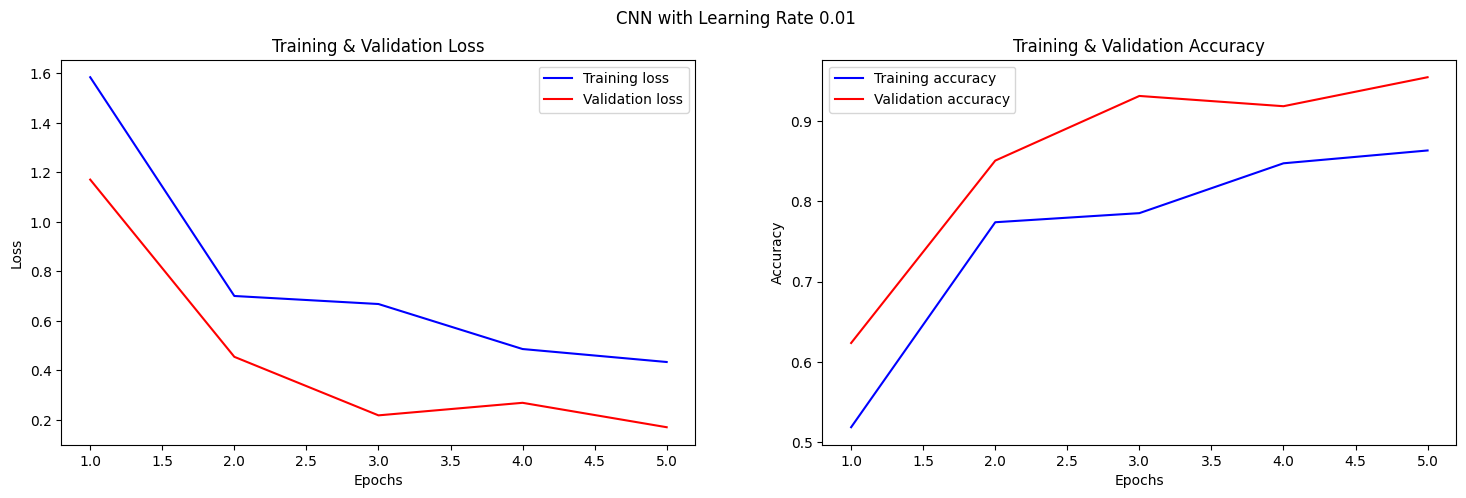

In [191]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_cnn_lr1, title='CNN with Learning Rate 0.01')

Generating predictions from validation data...
1/1 [==============================] - 0s 128ms/step


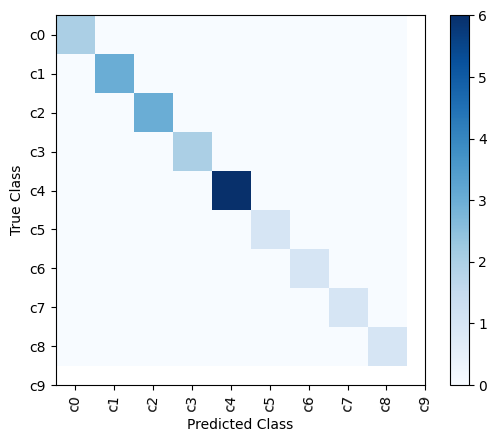

In [192]:
# Plotting confusion matrix
plot_confusion_matrix(model_cnn_lr1, validation_generator_128, classes)

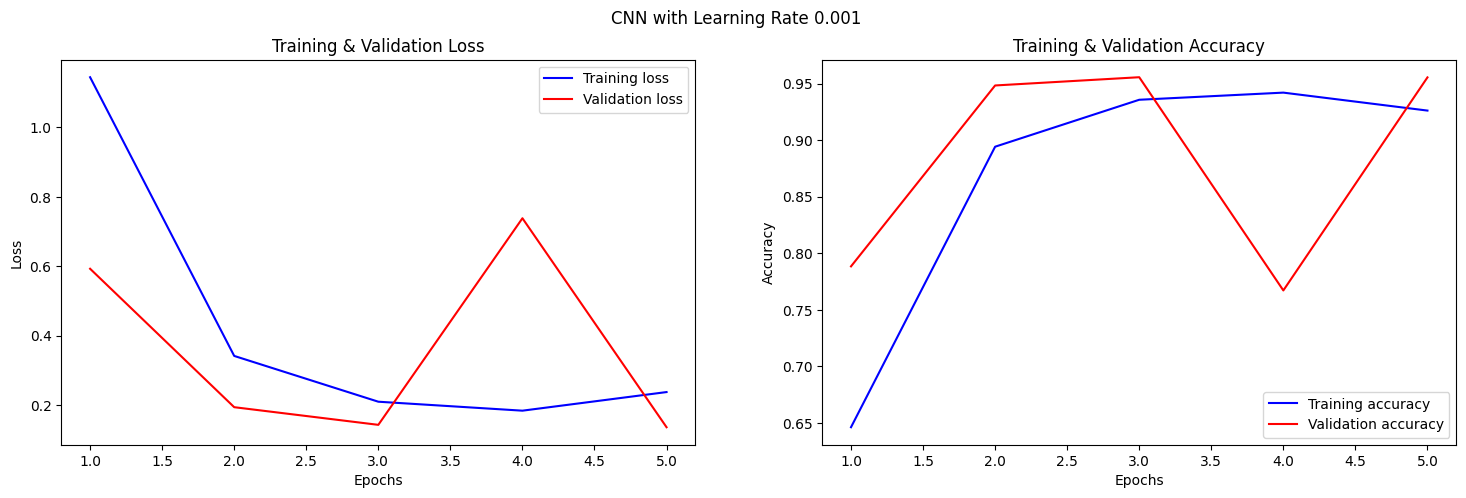

In [193]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_cnn_lr2, title='CNN with Learning Rate 0.001')

Generating predictions from validation data...
1/1 [==============================] - 0s 124ms/step


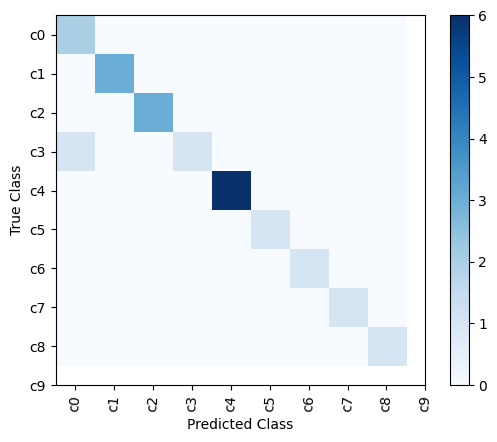

In [194]:
# Plotting confusion matrix
plot_confusion_matrix(model_cnn_lr2, validation_generator_128, classes)

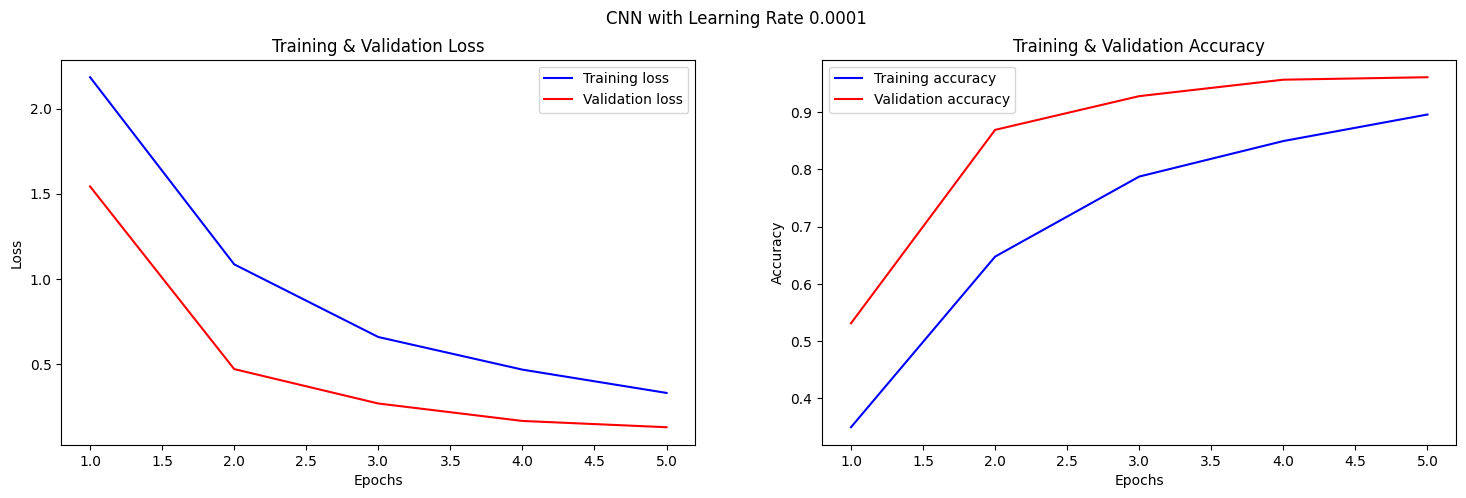

In [195]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_cnn_lr3, title='CNN with Learning Rate 0.0001')

Generating predictions from validation data...
1/1 [==============================] - 0s 126ms/step


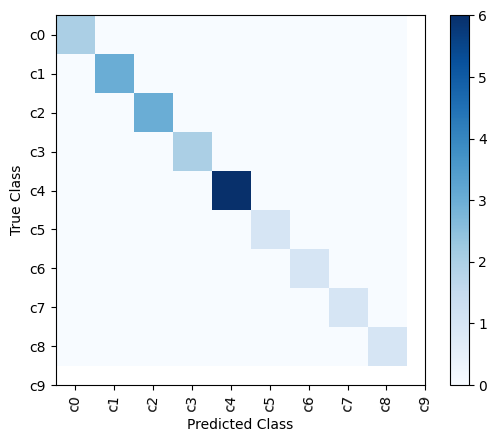

In [196]:
# Plotting confusion matrix
plot_confusion_matrix(model_cnn_lr3, validation_generator_128, classes)

## B. Transfer Learning: VGG16

Based on the VGG16 model training, the learning rate of 0.001 seems to perform best:

**1. Higher validation accuracy:** At the learning rate of 0.001, the final validation accuracy reached approximately 99.72%, which is higher than what is achieved with the other learning rates (99.30% for 0.1 and 99.09% for 0.01).

**2. Lower validation loss:** The learning rate of 0.001 achieved the lowest validation loss of 0.0148, indicating that the model's predictions are closer to the true values in the validation set compared to the other learning rates.

**3. Stable Convergence:** The model with a learning rate of 0.001 shows stable convergence with a consistent decrease in loss and increase in accuracy over the epochs. In contrast, the model with a learning rate of 0.1 showed a more abrupt change in performance which may indicate less stable convergence.

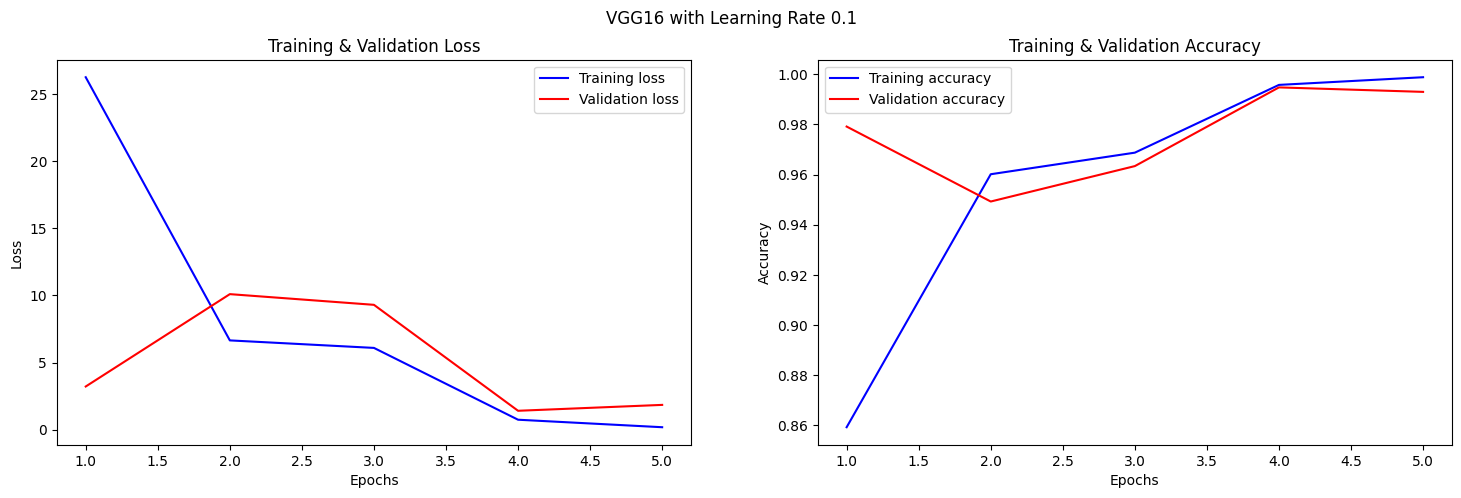

In [197]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_vgg16_lr1, title='VGG16 with Learning Rate 0.1')

Generating predictions from validation data...
1/1 [==============================] - 1s 1s/step


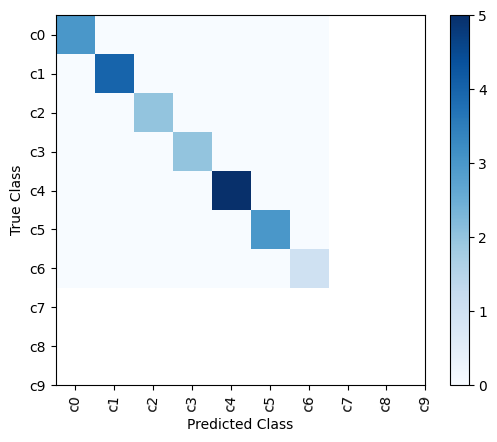

In [198]:
# Plotting confusion matrix
plot_confusion_matrix(model_vgg16_lr1, validation_generator_224, classes)

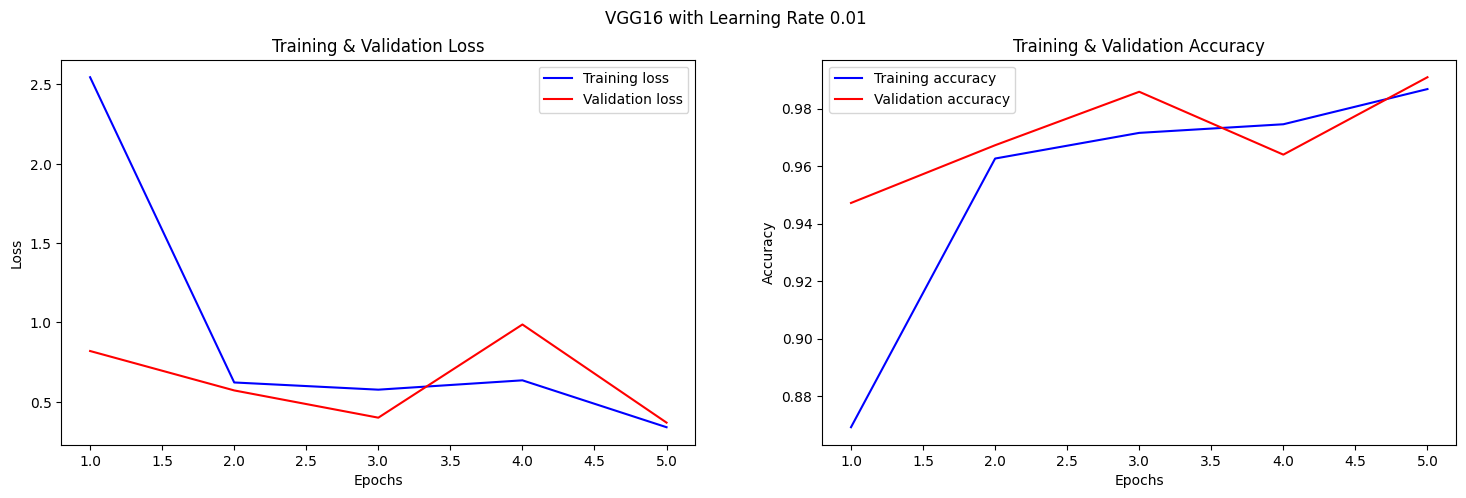

In [199]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_vgg16_lr2, title='VGG16 with Learning Rate 0.01')

Generating predictions from validation data...
1/1 [==============================] - 1s 1s/step


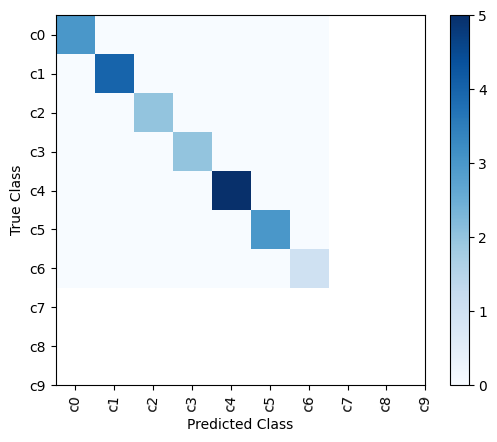

In [200]:
# Plotting confusion matrix
plot_confusion_matrix(model_vgg16_lr2, validation_generator_224, classes)

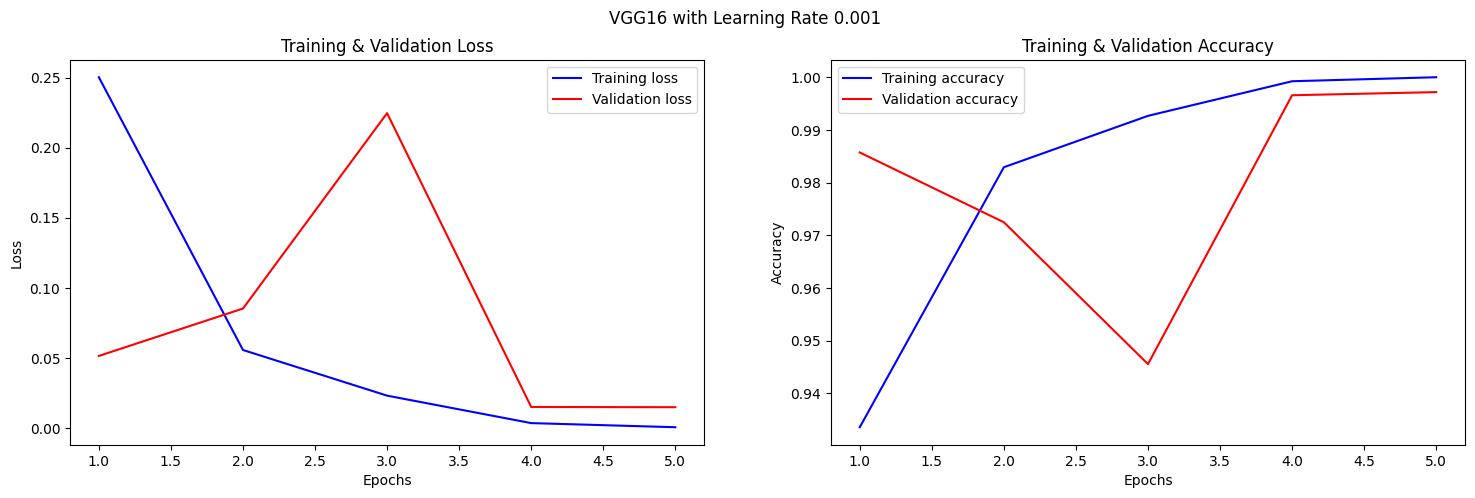

In [201]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_vgg16_lr3, title='VGG16 with Learning Rate 0.001')

Generating predictions from validation data...
1/1 [==============================] - 1s 1s/step


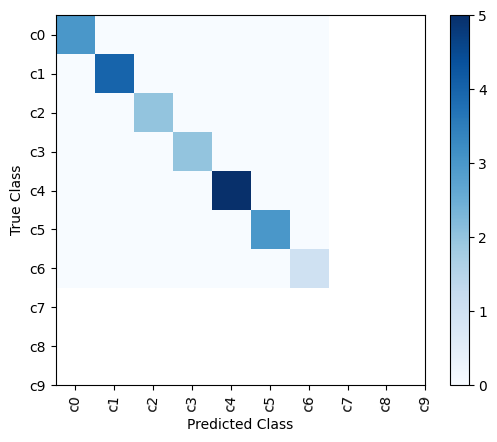

In [202]:
# Plotting confusion matrix
plot_confusion_matrix(model_vgg16_lr3, validation_generator_224, classes)

## C. Transfer Learning: MobileNetV3

Based on the MobileNetV3 model training, the learning rate of 0.001 seems to perform best:

**1. Higher validation accuracy:** At the learning rate of 0.001, the final validation accuracy reached approximately 96.32%, which is higher than what is achieved with the other learning rates.

**2. Stable Convergence:** The model with a learning rate of 0.001 seems to have a more stable decrease in loss and increase in accuracy over epochs compared to the learning rate of 0.01, which shows fluctuating performance in validation accuracy.

**3. Not too slow:** The learning rate of 0.0001 is too slow, and the model has not yet converged to its peak performance within the 5 epochs. It has the potential to perform well but will require more training time which requires more computing power and time.

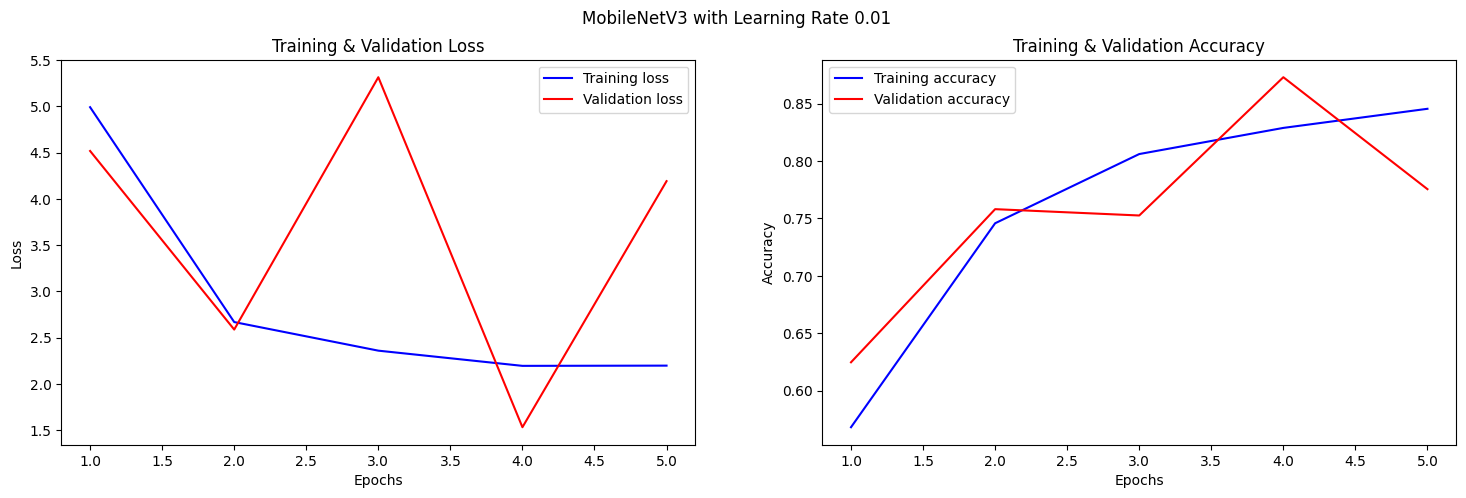

In [203]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_mobilenetv3_lr1, title='MobileNetV3 with Learning Rate 0.01')

Generating predictions from validation data...
1/1 [==============================] - 1s 662ms/step


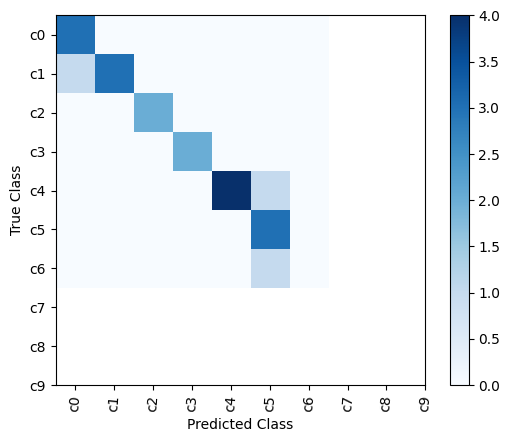

In [204]:
# Plotting confusion matrix
plot_confusion_matrix(model_mobilenetv3_lr1, validation_generator_224, classes)

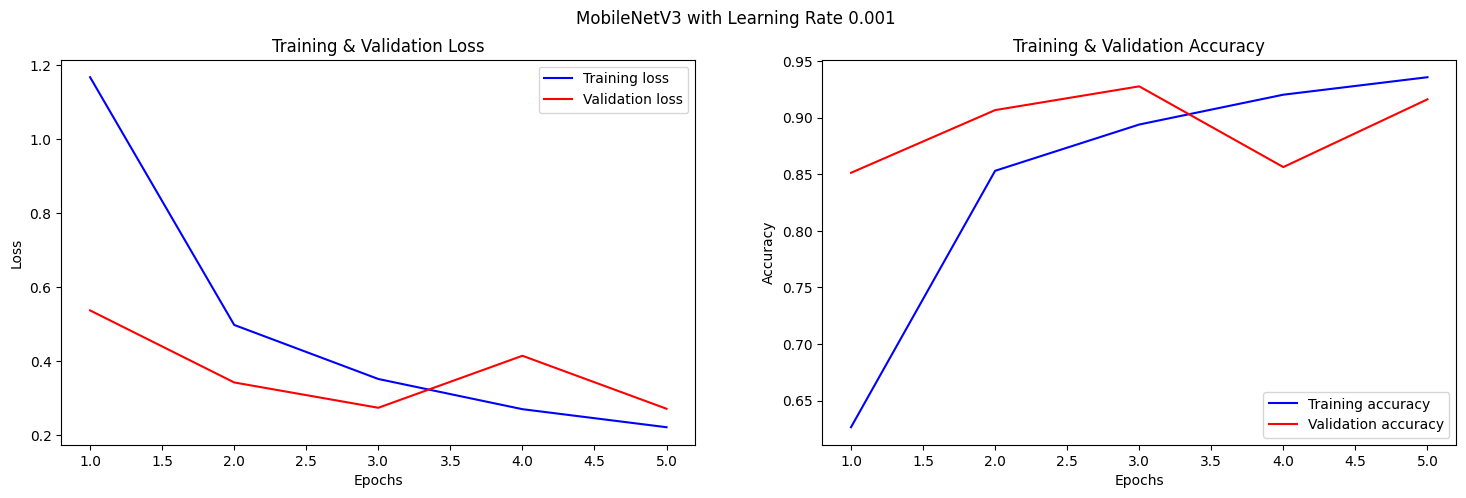

In [205]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_mobilenetv3_lr2, title='MobileNetV3 with Learning Rate 0.001')

Generating predictions from validation data...
1/1 [==============================] - 1s 664ms/step


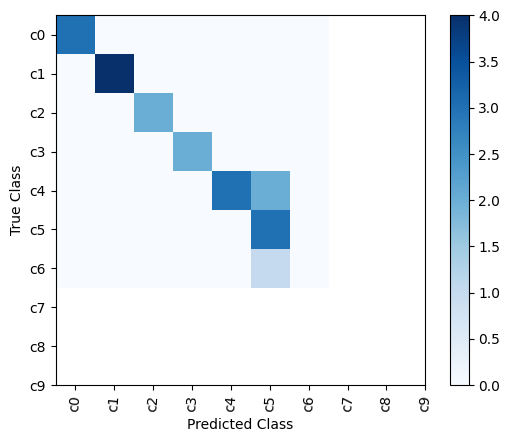

In [206]:
# Plotting confusion matrix
plot_confusion_matrix(model_mobilenetv3_lr2, validation_generator_224, classes)

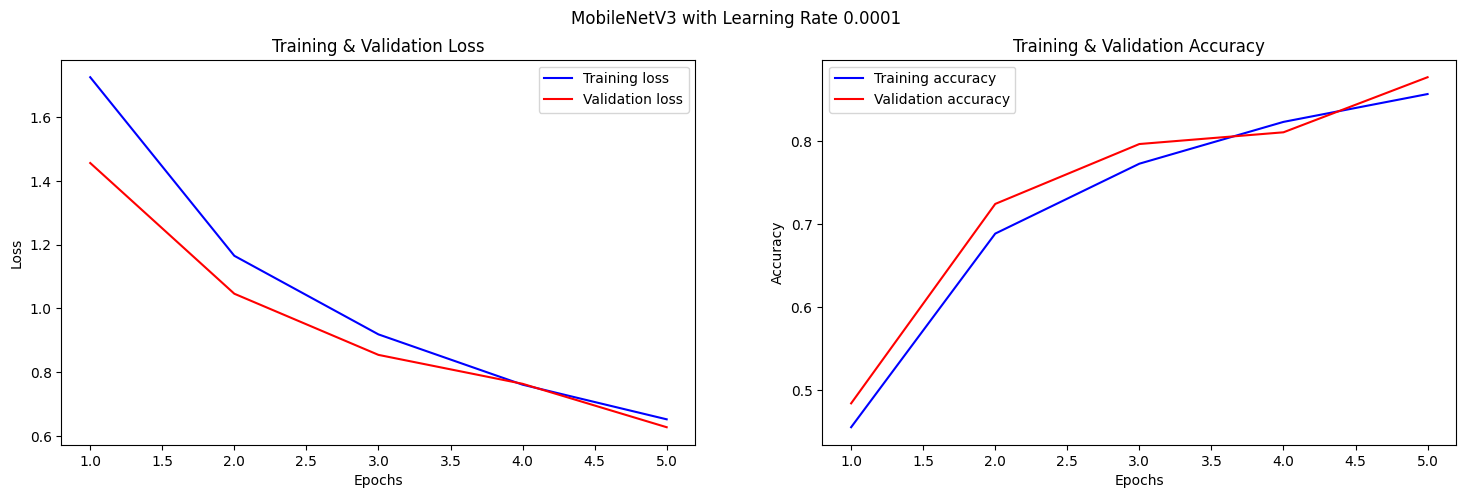

In [207]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_mobilenetv3_lr3, title='MobileNetV3 with Learning Rate 0.0001')

Generating predictions from validation data...
1/1 [==============================] - 1s 643ms/step


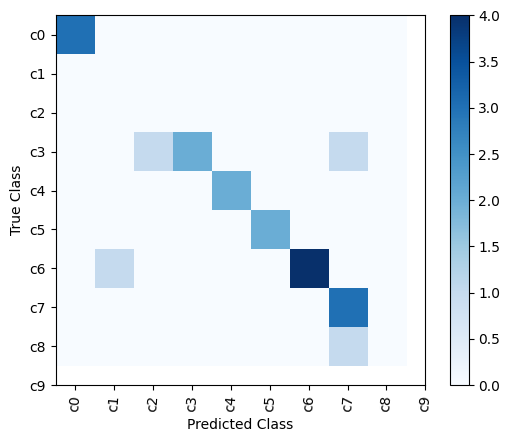

In [208]:
# Plotting confusion matrix
plot_confusion_matrix(model_mobilenetv3_lr3, validation_generator_224, classes)

# 6. Hyperparameter tuning

To tune our models and hence increase both the training and validation accuracy while avoiding overfitting, we are going to test the transfer learning models with the Nadam optimizer. The Nadam optimizer is basically the Adam optimizer but with Nesterov momentum. Including the Nesterov momentum might lead to better convergence properties of our models as it calculates the gradient at the position after the momentum update instead of calculating it at the current position.

### Customization of Additional Layers

In addition, we are going to conditionally add extra layers to fine-tune the models:

- **Dense Layer (Optional)**: This layer is a fully connected layer. This means all the neurons in a layer are connected to those in the next layer which might help in learning non-linear combinations of our features.

- **Dropout Layer (Optional)**: This layer randomly sets a fraction (in this case, 50%) of input units to 0 at each update during training time and helps to prevent overiffting.

- **Batch Normalization Layer (Optional)**: This layer normalizes the activations of the previous layer at each batch. It helps in improving the speed, performance, and stability of the pre-trained neural network.

## A. Convolutional Neural Network

In [215]:
def create_cnn_model_tuned(input_shape, num_classes, learning_rate, use_dense=True, use_dropout=True, use_batchnorm=True):
    cnn_model = Sequential()
    
    # First Convolutional Block
    cnn_model.add(Conv2D(32, (6, 6), input_shape=input_shape, activation='relu'))
    if use_batchnorm:
        cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
        cnn_model.add(Dropout(0.25))
    
    # Second Convolutional Block
    cnn_model.add(Conv2D(64, (5, 5), activation='relu'))
    if use_batchnorm:
        cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
        cnn_model.add(Dropout(0.25))
    
    # Third Convolutional Block
    cnn_model.add(Conv2D(128, (4, 4), activation='relu'))
    if use_batchnorm:
        cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
        cnn_model.add(Dropout(0.25))
    
    # Fourth Convolutional Block
    cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
    if use_batchnorm:
        cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
        cnn_model.add(Dropout(0.25))
    
    # Fully connected layer
    cnn_model.add(Flatten())
    if use_dense:
        cnn_model.add(Dense(512, activation='relu'))
        if use_batchnorm:
            cnn_model.add(BatchNormalization())
        if use_dropout:
            cnn_model.add(Dropout(0.5))
    
    # Output layer
    cnn_model.add(Dense(num_classes, activation='softmax'))
    
    # Define the optimizer with the specified learning rate
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    #optimizer = tf.optimizers.Nadam(learning_rate=learning_rate)
    
    # Compile the model
    cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return cnn_model


In [216]:
# Creating a model with specific layer settings
lr = 0.001
model_cnn_tuned = create_cnn_model_tuned(train_generator_128.image_shape, train_generator_128.num_classes, lr,use_dense=True, use_dropout=False, use_batchnorm=True)

# Training the model
history_cnn_tuned = train_model(
    model=model_cnn_tuned,
    model_name="cnn_tuned",
    train_generator=train_generator_128,
    validation_generator=validation_generator_128,
    batch_size=batch_size
)

Epoch 1/5
785/785 - 141s - loss: 0.5170 - accuracy: 0.8401 - val_loss: 0.4299 - val_accuracy: 0.8805 - lr: 0.0010 - 141s/epoch - 180ms/step
Epoch 2/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


785/785 - 137s - loss: 0.1290 - accuracy: 0.9601 - val_loss: 0.4851 - val_accuracy: 0.8385 - lr: 0.0010 - 137s/epoch - 175ms/step
Epoch 3/5
785/785 - 148s - loss: 0.1200 - accuracy: 0.9621 - val_loss: 0.1009 - val_accuracy: 0.9705 - lr: 0.0010 - 148s/epoch - 188ms/step
Epoch 4/5
785/785 - 133s - loss: 0.0506 - accuracy: 0.9850 - val_loss: 0.0983 - val_accuracy: 0.9722 - lr: 0.0010 - 133s/epoch - 169ms/step
Epoch 5/5
785/785 - 137s - loss: 0.0515 - accuracy: 0.9851 - val_loss: 0.1139 - val_accuracy: 0.9677 - lr: 0.0010 - 137s/epoch - 174ms/step


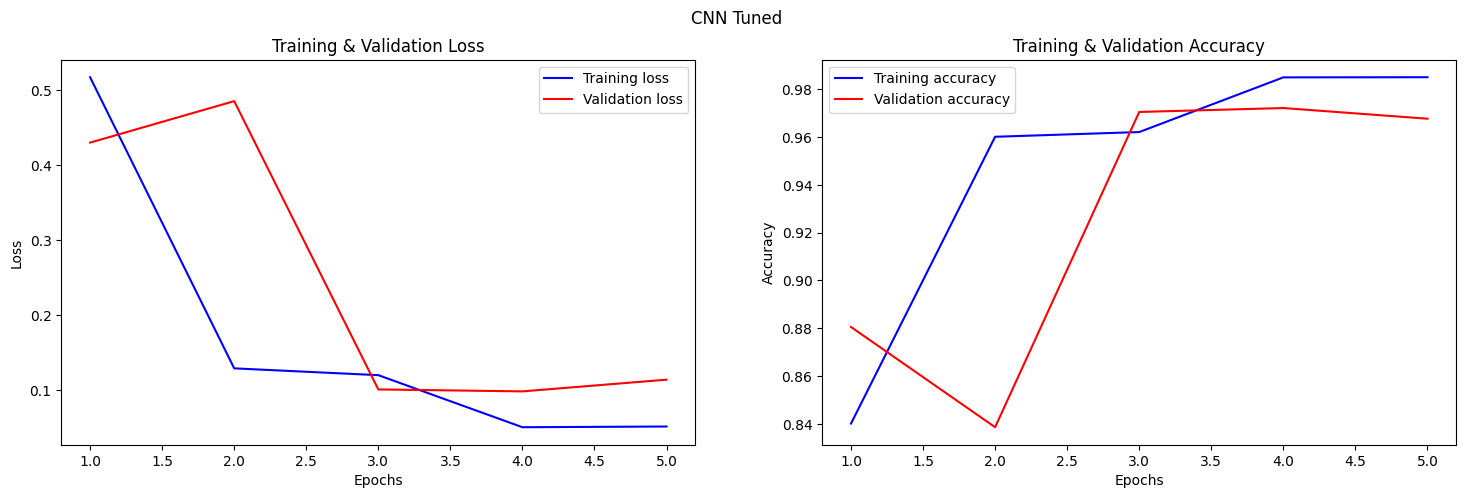

In [217]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_cnn_tuned, title='CNN Tuned')

Generating predictions from validation data...
1/1 [==============================] - 0s 177ms/step


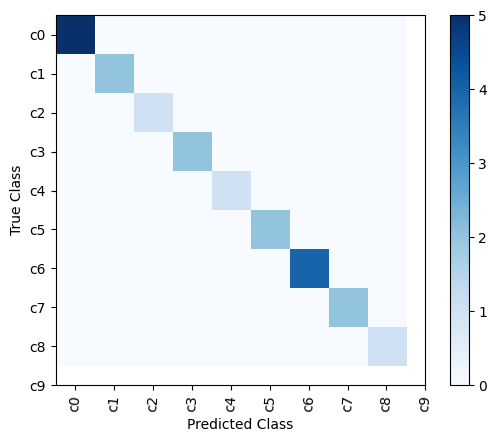

In [218]:
# Plotting confusion matrix
plot_confusion_matrix(model_cnn_tuned, validation_generator_128, classes)

## B. Transfer Learning: VGG16

In [209]:
def create_vgg16_model_tuned(input_shape, num_classes, learning_rate, use_dense=True, use_dropout=True, use_batchnorm=True):
    # Load the VGG16 model without the final output layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers
    x = Flatten()(base_model.output)
    
    # Conditionally add a Dense layer
    if use_dense:
        x = Dense(128, activation='relu')(x)
    
    # Conditionally add a Dropout layer
    if use_dropout:
        x = Dropout(0.5)(x)
    
    # Conditionally add a BatchNormalization layer
    if use_batchnorm:
        x = BatchNormalization()(x)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(x)

    # Define a new model
    model = Model(inputs=base_model.input, outputs=output)

    # Define optimizer with the specified learning rate
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    # optimizer = tf.optimizers.Nadam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [210]:
# Creating a model with specific layer settings
lr = 0.0001
model_vgg16_tuned = create_vgg16_model_tuned(train_generator_224.image_shape, train_generator_224.num_classes, lr,use_dense=True, use_dropout=False, use_batchnorm=True)

# Training the model
history_vgg16_tuned = train_model(
    model=model_vgg16_tuned,
    model_name="vgg16_tuned",
    train_generator=train_generator_224,
    validation_generator=validation_generator_224,
    batch_size=batch_size
)

Epoch 1/5
785/785 - 1348s - loss: 0.1639 - accuracy: 0.9610 - val_loss: 0.1270 - val_accuracy: 0.9603 - lr: 0.0010 - 1348s/epoch - 2s/step
Epoch 2/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


785/785 - 1334s - loss: 0.0232 - accuracy: 0.9961 - val_loss: 0.0271 - val_accuracy: 0.9937 - lr: 0.0010 - 1334s/epoch - 2s/step
Epoch 3/5
785/785 - 1332s - loss: 0.0105 - accuracy: 0.9984 - val_loss: 0.0446 - val_accuracy: 0.9900 - lr: 0.0010 - 1332s/epoch - 2s/step
Epoch 4/5
785/785 - 1341s - loss: 0.0237 - accuracy: 0.9939 - val_loss: 0.0558 - val_accuracy: 0.9847 - lr: 0.0010 - 1341s/epoch - 2s/step
Epoch 5/5
785/785 - 1390s - loss: 0.0052 - accuracy: 0.9995 - val_loss: 0.0107 - val_accuracy: 0.9978 - lr: 2.0000e-04 - 1390s/epoch - 2s/step


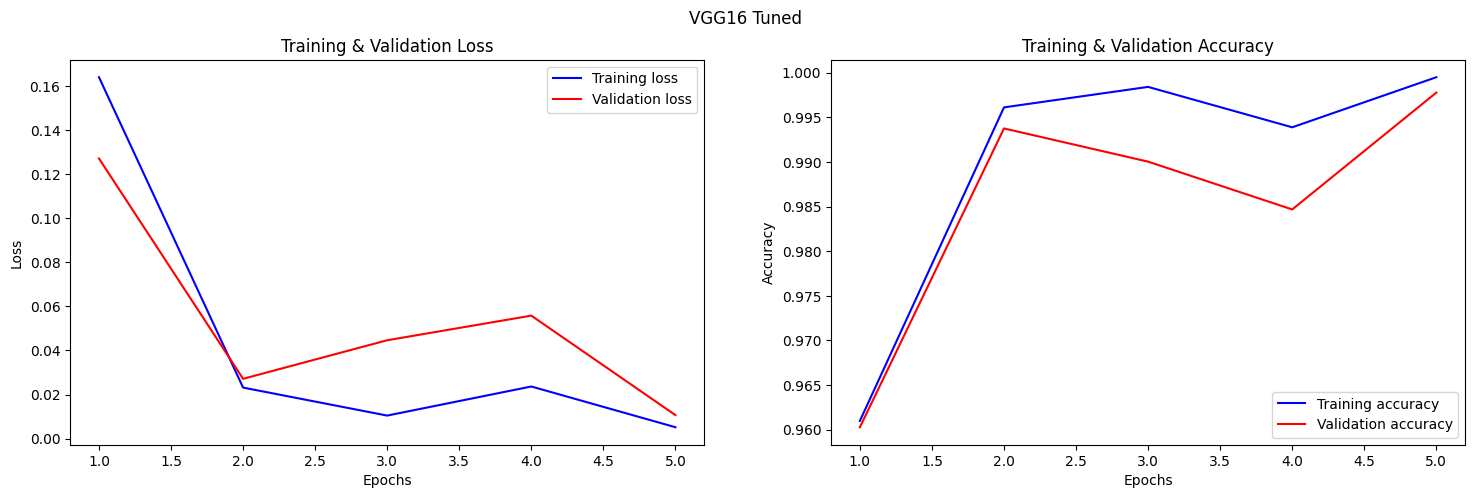

In [219]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_vgg16_tuned, title='VGG16 Tuned')

Generating predictions from validation data...
1/1 [==============================] - 2s 2s/step


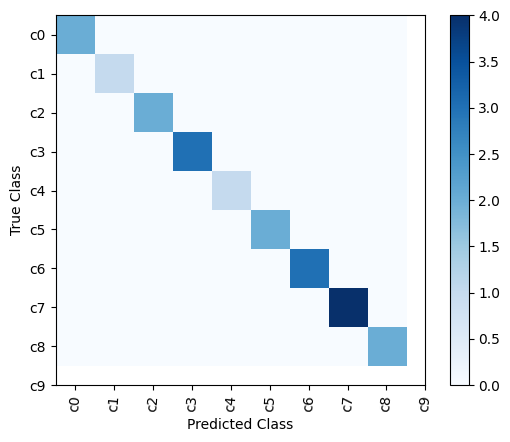

In [220]:
# Plotting confusion matrix
plot_confusion_matrix(model_vgg16_tuned, validation_generator_224, classes)

## C. Transfer Learning: MobileNetV3

In [211]:
def create_mobilenetv3_model_tuned(input_shape, num_classes, learning_rate, use_dense=True, use_dropout=True, use_batchnorm=True):
    # Load MobileNetV3 model without the final output layer
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    
    # Conditionally add a Dense layer
    if use_dense:
        x = Dense(128, activation='relu')(x)
    
    # Flatten the output
    x = Flatten()(x)
    
    # Conditionally add a Dropout layer
    if use_dropout:
        x = Dropout(0.5)(x)
    
    # Conditionally add a BatchNormalization layer
    if use_batchnorm:
        x = BatchNormalization()(x)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(x)

    # Define a new model
    model = Model(inputs=base_model.input, outputs=output)

    # Define optimizer with the specified learning rate
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    # optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [224]:
# Creating a model with specific layer settings
lr = 0.001
model_mobilenetv3_tuned = create_mobilenetv3_model_tuned(train_generator_224.image_shape, train_generator_224.num_classes, lr,use_dense=False, use_dropout=False, use_batchnorm=True)

# Training the model
history_mobilenetv3_tuned = train_model(
    model=model_mobilenetv3_tuned,
    model_name="mobilenetv3_tuned",
    train_generator=train_generator_224,
    validation_generator=validation_generator_224,
    batch_size=batch_size
)

Epoch 1/5
785/785 - 103s - loss: 1.6146 - accuracy: 0.4865 - val_loss: 1.2769 - val_accuracy: 0.6329 - lr: 0.0010 - 103s/epoch - 131ms/step
Epoch 2/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


785/785 - 101s - loss: 1.0937 - accuracy: 0.6775 - val_loss: 0.9243 - val_accuracy: 0.7469 - lr: 0.0010 - 101s/epoch - 128ms/step
Epoch 3/5
785/785 - 98s - loss: 0.8737 - accuracy: 0.7523 - val_loss: 0.7541 - val_accuracy: 0.8003 - lr: 0.0010 - 98s/epoch - 125ms/step
Epoch 4/5
785/785 - 96s - loss: 0.7390 - accuracy: 0.7963 - val_loss: 0.6472 - val_accuracy: 0.8332 - lr: 0.0010 - 96s/epoch - 122ms/step
Epoch 5/5
785/785 - 94s - loss: 0.6483 - accuracy: 0.8225 - val_loss: 0.5760 - val_accuracy: 0.8516 - lr: 0.0010 - 94s/epoch - 119ms/step


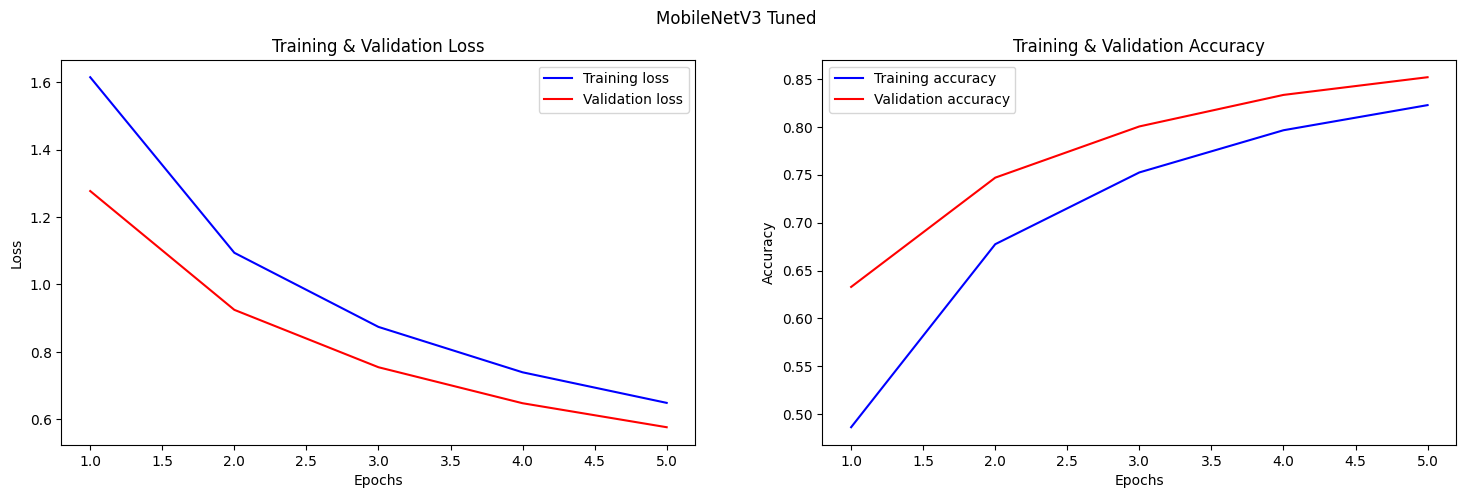

In [225]:
# Plotting loss and accuracy of training and validation
plot_training_history(history_mobilenetv3_tuned, title='MobileNetV3 Tuned')

Generating predictions from validation data...
1/1 [==============================] - 1s 1s/step


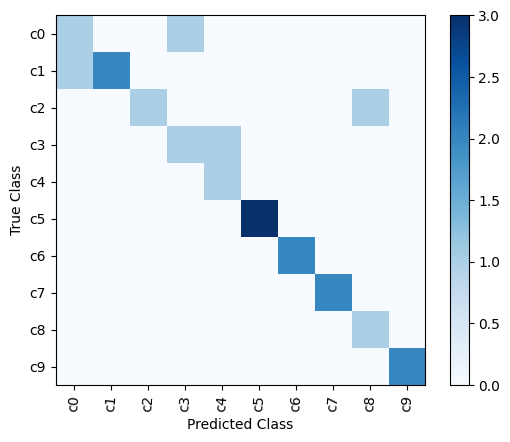

In [226]:
# Plotting confusion matrix
plot_confusion_matrix(model_mobilenetv3_tuned, validation_generator_224, classes)

# 7. Model Selection

In [213]:
def model_evaluation(model_histories, models, model_names, model_file_name):
    """
    Evaluate models based on validation accuracy and loss, and save the best model to a file.
    
    Args:
    - model_histories: List of history objects of the models
    - models: List of model objects
    - model_names: List of model names corresponding to the histories
    - model_file_name: The base file name to save the best model. The model name will be appended.
    
    """
    best_val_accuracy = 0
    best_val_loss = float("inf")
    best_model = None
    best_model_name = None
    
    for history, model, model_name in zip(model_histories, models, model_names):
        val_accuracy = history.history['val_accuracy'][-1]
        val_loss = history.history['val_loss'][-1]
        
        # Check if this model has a higher accuracy or lower loss than the current best
        if val_accuracy > best_val_accuracy or (val_accuracy == best_val_accuracy and val_loss < best_val_loss):
            best_val_accuracy = val_accuracy
            best_val_loss = val_loss
            best_model = model
            best_model_name = model_name
            
    # Save the best model
    if best_model is not None:
        best_model.save(f"{model_file_name}_{best_model_name}.keras")
    else:
        print("No model to save.")

In [227]:
# Saving best model for testing
model_histories = [history_cnn_tuned, history_vgg16_tuned, history_mobilenetv3_tuned]
models = [model_cnn_tuned, model_vgg16_tuned, model_mobilenetv3_tuned]
model_names = ["CNN Tuned", "VGG16 Tuned", "MobileNet Tuned"]

model_evaluation(
    model_histories=model_histories,
    models=models,
    model_names=model_names,
    model_file_name="best_model"
)

# 8. Model Deployment

Finally, we are going to deploy the best model, resize the images to 128x128 pixels and apply to the test dataset.

In [228]:
# Helper function to resize image
def resize_image(src_img, size=(128, 128), bg_color="white"):
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)

    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)

    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))

    # Return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):    
    # We need to format the input to match the training data
    # The data generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    img_features = image_array.astype('float32')
    img_features /= 255
    
    # Predict the class of each input image
    predictions = classifier.predict(img_features)
    
    predicted_classes = []
    for prediction in predictions:
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(classes[int(class_idx)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


1/1 [==============================] - 0s 17ms/step


/var/folders/5f/06bzwqjd1kl3lkb5zlxrzcp00000gn/T/ipykernel_8285/221993211.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  src_img.thumbnail(size, Image.ANTIALIAS)


1/1 [==============================] - 0s 13ms/step


KeyboardInterrupt: 

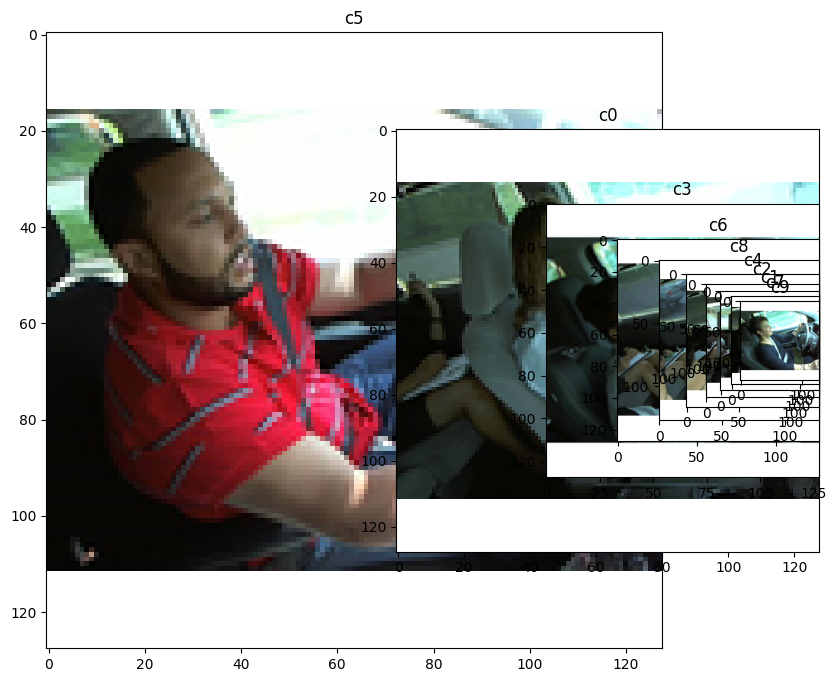

In [230]:
%matplotlib inline

# Define the path to the test data directory
test_data = '../imgs/test'

# Load the saved model
modelFileName = 'best_model.h5'
best_model = load_model(modelFileName) 

# Get the list of test image files
test_image_files = os.listdir(test_data)

# Empty array on which to store the images
image_arrays = []

size = (128, 128)
background_color = "white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_data, test_image_files[file_idx]))
    
    # resize the image
    resized_img = np.array(resize_image(img, size, background_color))
    
    # Add the image to the array of images
    image_arrays.append(resized_img)

# Get predictions from the array of image arrays
predictions = predict_image(best_model, np.array(image_arrays))

# Plot each image with its corresponding prediction
for idx in range(len(predictions)):
    a = fig.add_subplot(1, len(predictions), idx + 1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])

# 9. Conclusion

By tuning the hyperparameters such as including batch normalization and dropout to prevent overfitting and more dense layers to take the extracted features from the preceding layers and map them to the desired output classes. Hence, we can reduce the dimensionality of the feature representations and capture the most relevant information for our model.

By trying out a different optimizer, Nadam, we could not improve the performance of our models (e.g. MobileNetV3 with accuracy of 85%). However, the following hyperparamters have been tuned:

**1. CNN: Improvement Through Additional Dense Layer and Batch Normalization**

In the custom CNN model, incorporating a dense layer and employing batch normalization has led to a significant enhancement in performance. The accuracy increased from 92% to 98%, indicating a more effective model. The batch normalization probably stabilizes and accelerates the learning proces while the dense layer improved the cnn to better learn the feature combinations.

**2. VGG16: No improvement** 

Although it did not predict class 8 and 9, this model was able to predict the other classes quite well and showed a low loss, both in training and validation. However, adding a dense layer did not improve the model performance although it is almost perfect.

**3. MobileNetV3:** 

Using batch normalization did not improve the performance of the model. In addition, there seems to be some inaccuracy in predicting the true classes.

To conclude, the VGG16 model performs the best with an accuracy of 99,61% on the training data. 